In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("..")
import geojson
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from pyproj import Proj, transform
import pickle
import open_cp
import gentex

In [2]:
from services import prediction_metrics
from services.prediction_experiment import PredictionExperiment
from services.process_data import ProcessData

Failed to import `rtree`.
Failed to import `rtree`.


## Built-in

In [3]:
def get_hit_rate_from_dict(row,column,coverage):
    return row[column][coverage]

In [4]:
def normalize_grid_prediction(row, column_name):
    xoffset = row[column_name]._xoffset
    yoffset = row[column_name]._yoffset
    xsize = row[column_name]._xsize
    ysize = row[column_name]._ysize
    matrix_norm = row[column_name]._matrix.copy()
    # Uses 1 division and matix.size multiplications, multiplication is faster than division
    matrix_norm *= 1/row[column_name]._matrix.max()
    return open_cp.predictors.GridPredictionArray(xsize=xsize,ysize=ysize,matrix=matrix_norm,xoffset=xoffset,yoffset=yoffset)
    

### Texture features

In [5]:
texm = ['CM Entropy',
        'EM Entropy',
        'Statistical Complexity',
        'Energy Uniformity',
        'Maximum Probability',
        'Contrast',
        'Inverse Difference Moment',
        'Correlation',
        'Homogeneity',
        'Multifractal Spectrum Energy Range',
        'Multifractal Spectrum Entropy Range']

## Load prediction results

In [6]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_siedco_prediction.pkl','rb')
loaded_siedco = pickle.load(infile)
infile.close()

## Normalize prediction intensity risk maps

In [7]:
loaded_siedco['prediction_normalized'] = loaded_siedco.apply(lambda row: normalize_grid_prediction(row,'prediction'), axis=1)

In [8]:
# Delete not-normalized prediction columns
loaded_siedco.drop(columns=['prediction'], inplace=True)

### Rename columns to merge df

In [9]:
loaded_siedco = loaded_siedco.rename(columns={'prediction_normalized': 'prediction_siedco', 'eval_pts': 'eval_pts_siedco','initial-date':'initial-date-siedco','final-date':'final-date-siedco'})

## Compute texture features

In [10]:
def to_gray_scale(matrix):
    matrix_int = (matrix.copy() * 254).astype(int)
    #matrix_offset = np.ones([matrix.shape[0],matrix.shape[1]]) # to avoid elements with 0 value (measures as entropy can be computed)
    return (matrix_int).astype(int)

In [11]:
current_prediction = loaded_siedco['prediction_siedco'][0]

### Different directions on co occurrence matrix

In [12]:
flag_array = True
texture_measures = np.array([])
distance = [1,2,3,5,8,10,15,20,30,40,50]
matrix = to_gray_scale(current_prediction._matrix)
mask = np.ones([matrix.shape[0],matrix.shape[1]])

In [ ]:
for d in distance:
    element = np.array(['horizontal',d])
    offset = [[1*d,0],[-1*d,0]]
    cm = gentex.comat.comat_mult(matrix, mask, offset, levels=255)

    mytex = gentex.texmeas.Texmeas(comat=cm, coordmom=2, probmom=1)
    for meas in texm:
        mytex.calc_measure(meas)
        #print(f'{meas} = {mytex.val}')
        element = np.append(element, mytex.val)
    flag_array, texture_measures = ProcessData.fill_array(flag_array, texture_measures, element)

In [14]:
for d in distance:
    element = np.array(['vertical',d])
    offset = [[0,1*d],[0,-1*d]]
    cm = gentex.comat.comat_mult(matrix, mask, offset, levels=255)

    mytex = gentex.texmeas.Texmeas(comat=cm, coordmom=2, probmom=1)
    for meas in texm:
        mytex.calc_measure(meas)
        #print(f'{meas} = {mytex.val}')
        element = np.append(element, mytex.val)
    flag_array, texture_measures = ProcessData.fill_array(flag_array, texture_measures, element)

In [15]:
for d in distance:
    element = np.array(['diagonal',d])
    offset = [[1*d,1*d],[-1*d,-1*d],[1*d,-1*d],[-1*d,1*d]]
    cm = gentex.comat.comat_mult(matrix, mask, offset, levels=255)

    mytex = gentex.texmeas.Texmeas(comat=cm, coordmom=2, probmom=1)
    for meas in texm:
        mytex.calc_measure(meas)
        #print(f'{meas} = {mytex.val}')
        element = np.append(element, mytex.val)
    flag_array, texture_measures = ProcessData.fill_array(flag_array, texture_measures, element)

In [16]:
for d in distance:
    element = np.array(['all',d])
    offset = [[1*d,0],[-1*d,0],[0,1*d],[0,-1*d],[1*d,1*d],[-1*d,-1*d],[1*d,-1*d],[-1*d,1*d]]
    cm = gentex.comat.comat_mult(matrix, mask, offset, levels=255)

    mytex = gentex.texmeas.Texmeas(comat=cm, coordmom=2, probmom=1)
    for meas in texm:
        mytex.calc_measure(meas)
        #print(f'{meas} = {mytex.val}')
        element = np.append(element, mytex.val)
    flag_array, texture_measures = ProcessData.fill_array(flag_array, texture_measures, element)

In [17]:
textures_df = pd.DataFrame(texture_measures, columns =['direction','distance','CM Entropy',
                                                        'EM Entropy',
                                                        'Statistical Complexity',
                                                        'Energy Uniformity',
                                                        'Maximum Probability',
                                                        'Contrast',
                                                        'Inverse Difference Moment',
                                                        'Correlation',
                                                        'Homogeneity',
                                                        'Multifractal Spectrum Energy Range',
                                                        'Multifractal Spectrum Entropy Range'])

In [18]:
textures_df[['CM Entropy','Energy Uniformity','Maximum Probability','Contrast','Inverse Difference Moment','Correlation','Homogeneity','Multifractal Spectrum Energy Range','Multifractal Spectrum Entropy Range']] = textures_df[['CM Entropy','Energy Uniformity','Maximum Probability','Contrast','Inverse Difference Moment','Correlation','Homogeneity','Multifractal Spectrum Energy Range','Multifractal Spectrum Entropy Range']].apply(pd.to_numeric)


In [19]:
horizontal = textures_df[textures_df['direction']=='horizontal']
vertical = textures_df[textures_df['direction']=='vertical']
diagonal = textures_df[textures_df['direction']=='diagonal']
all_directions = textures_df[textures_df['direction']=='all']

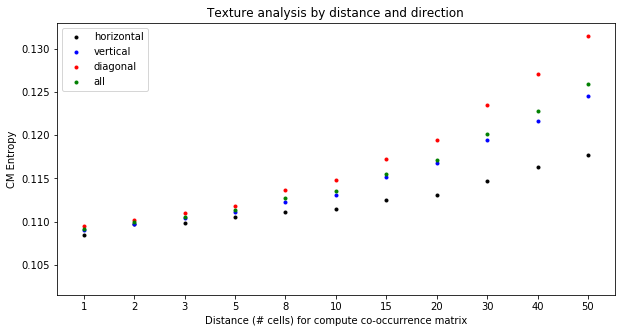

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
horizontal_dir = ax.scatter(horizontal['distance'].values,horizontal['CM Entropy'].values, marker=".",color='black')
vertical_dir = ax.scatter(vertical['distance'].values,vertical['CM Entropy'].values, marker=".",color='blue')
diagonal_dir = ax.scatter(diagonal['distance'].values,diagonal['CM Entropy'].values, marker=".",color='red')
all_dirs = ax.scatter(all_directions['distance'].values,all_directions['CM Entropy'].values, marker=".",color='green')

ax.set_title('Texture analysis by distance and direction')
ax.legend((horizontal_dir, vertical_dir, diagonal_dir, all_dirs),('horizontal', 'vertical', 'diagonal', 'all'))
plt.xlabel('Distance (# cells) for compute co-occurrence matrix')
plt.ylabel('CM Entropy')
plt.show()

In [21]:
stats_complex = []
for e in vertical['Statistical Complexity'].values:
    stats_complex.append(abs(complex(e)))

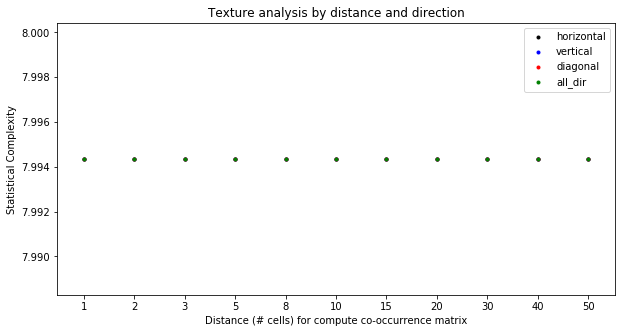

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
horizontal_dir = ax.scatter(horizontal['distance'].values,stats_complex, marker=".",color='black')
vertical_dir = ax.scatter(vertical['distance'].values,stats_complex, marker=".",color='blue')
diagonal_dir = ax.scatter(diagonal['distance'].values,stats_complex, marker=".",color='red')
all_dirs = ax.scatter(all_directions['distance'].values,stats_complex, marker=".",color='green')

ax.set_title('Texture analysis by distance and direction')
ax.legend((horizontal_dir, vertical_dir, diagonal_dir, all_dirs),('horizontal', 'vertical', 'diagonal', 'all_dir'))
plt.xlabel('Distance (# cells) for compute co-occurrence matrix')
plt.ylabel('Statistical Complexity')
plt.show()

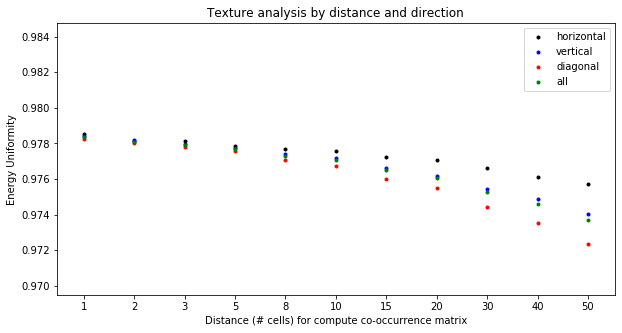

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
horizontal_dir = ax.scatter(horizontal['distance'].values,horizontal['Energy Uniformity'].values, marker=".",color='black')
vertical_dir = ax.scatter(vertical['distance'].values,vertical['Energy Uniformity'].values, marker=".",color='blue')
diagonal_dir = ax.scatter(diagonal['distance'].values,diagonal['Energy Uniformity'].values, marker=".",color='red')
all_dirs = ax.scatter(all_directions['distance'].values,all_directions['Energy Uniformity'].values, marker=".",color='green')

ax.set_title('Texture analysis by distance and direction')
ax.legend((horizontal_dir, vertical_dir, diagonal_dir, all_dirs),('horizontal', 'vertical', 'diagonal', 'all'))
plt.xlabel('Distance (# cells) for compute co-occurrence matrix')
plt.ylabel('Energy Uniformity')
plt.show()

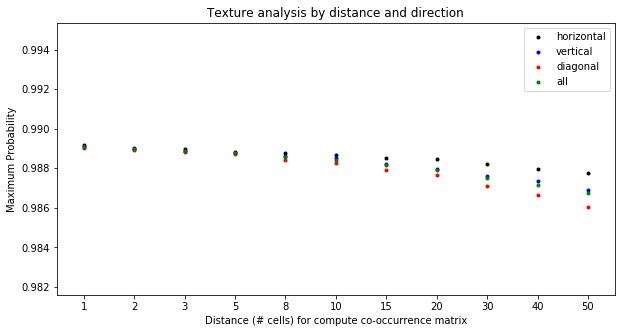

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
horizontal_dir = ax.scatter(horizontal['distance'].values,horizontal['Maximum Probability'].values, marker=".",color='black')
vertical_dir = ax.scatter(vertical['distance'].values,vertical['Maximum Probability'].values, marker=".",color='blue')
diagonal_dir = ax.scatter(diagonal['distance'].values,diagonal['Maximum Probability'].values, marker=".",color='red')
all_dirs = ax.scatter(all_directions['distance'].values,all_directions['Maximum Probability'].values, marker=".",color='green')

ax.set_title('Texture analysis by distance and direction')
ax.legend((horizontal_dir, vertical_dir, diagonal_dir, all_dirs),('horizontal', 'vertical', 'diagonal', 'all'))
plt.xlabel('Distance (# cells) for compute co-occurrence matrix')
plt.ylabel('Maximum Probability')
plt.show()

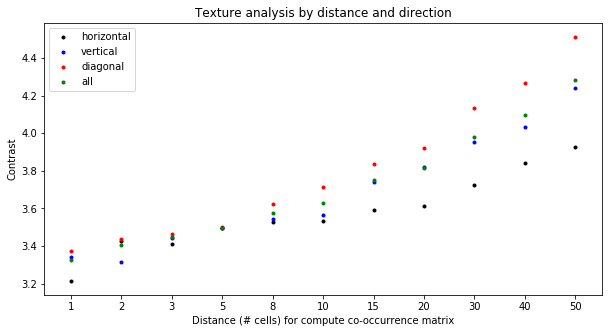

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
horizontal_dir = ax.scatter(horizontal['distance'].values,horizontal['Contrast'].values, marker=".",color='black')
vertical_dir = ax.scatter(vertical['distance'].values,vertical['Contrast'].values, marker=".",color='blue')
diagonal_dir = ax.scatter(diagonal['distance'].values,diagonal['Contrast'].values, marker=".",color='red')
all_dirs = ax.scatter(all_directions['distance'].values,all_directions['Contrast'].values, marker=".",color='green')

ax.set_title('Texture analysis by distance and direction')
ax.legend((horizontal_dir, vertical_dir, diagonal_dir, all_dirs),('horizontal', 'vertical', 'diagonal', 'all'))
plt.xlabel('Distance (# cells) for compute co-occurrence matrix')
plt.ylabel('Contrast')
plt.show()

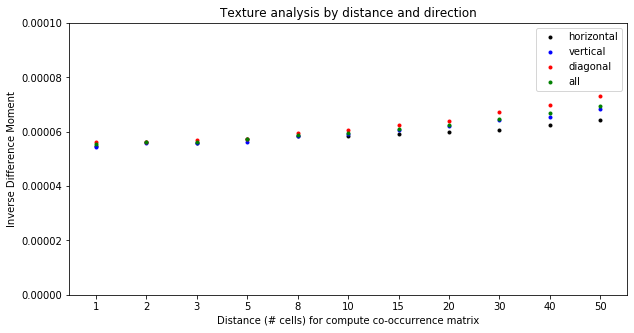

In [35]:
fig, ax = plt.subplots(figsize=(10,5))
horizontal_dir = ax.scatter(horizontal['distance'].values,horizontal['Inverse Difference Moment'].values, marker=".",color='black')
vertical_dir = ax.scatter(vertical['distance'].values,vertical['Inverse Difference Moment'].values, marker=".",color='blue')
diagonal_dir = ax.scatter(diagonal['distance'].values,diagonal['Inverse Difference Moment'].values, marker=".",color='red')
all_dirs = ax.scatter(all_directions['distance'].values,all_directions['Inverse Difference Moment'].values, marker=".",color='green')

ax.set_title('Texture analysis by distance and direction')
ax.legend((horizontal_dir, vertical_dir, diagonal_dir, all_dirs),('horizontal', 'vertical', 'diagonal', 'all'))
ax.set_ylim(0,0.0001)
plt.xlabel('Distance (# cells) for compute co-occurrence matrix')
plt.ylabel('Inverse Difference Moment')
plt.show()

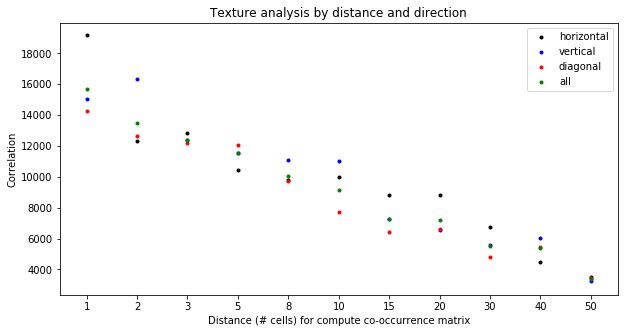

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
horizontal_dir = ax.scatter(horizontal['distance'].values,horizontal['Correlation'].values, marker=".",color='black')
vertical_dir = ax.scatter(vertical['distance'].values,vertical['Correlation'].values, marker=".",color='blue')
diagonal_dir = ax.scatter(diagonal['distance'].values,diagonal['Correlation'].values, marker=".",color='red')
all_dirs = ax.scatter(all_directions['distance'].values,all_directions['Correlation'].values, marker=".",color='green')

ax.set_title('Texture analysis by distance and direction')
ax.legend((horizontal_dir, vertical_dir, diagonal_dir, all_dirs),('horizontal', 'vertical', 'diagonal', 'all'))
plt.xlabel('Distance (# cells) for compute co-occurrence matrix')
plt.ylabel('Correlation')
plt.show()

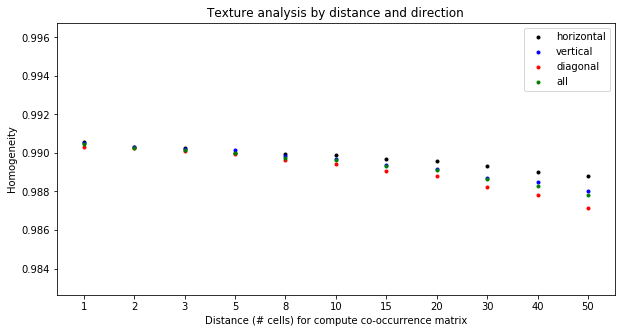

In [37]:
fig, ax = plt.subplots(figsize=(10,5))
horizontal_dir = ax.scatter(horizontal['distance'].values,horizontal['Homogeneity'].values, marker=".",color='black')
vertical_dir = ax.scatter(vertical['distance'].values,vertical['Homogeneity'].values, marker=".",color='blue')
diagonal_dir = ax.scatter(diagonal['distance'].values,diagonal['Homogeneity'].values, marker=".",color='red')
all_dirs = ax.scatter(all_directions['distance'].values,all_directions['Homogeneity'].values, marker=".",color='green')

ax.set_title('Texture analysis by distance and direction')
ax.legend((horizontal_dir, vertical_dir, diagonal_dir, all_dirs),('horizontal', 'vertical', 'diagonal', 'all'))
plt.xlabel('Distance (# cells) for compute co-occurrence matrix')
plt.ylabel('Homogeneity')
plt.show()